In [1]:
#importing packages
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
#import torch.nn.functional as F

import copy

In [2]:
# Hyper parameter settings
EPOCH = 10 # Number of times to traverse the data set
BATCH_SIZE = 64 # Batch size (batch_size)
LR = 0.01 # learning rate

In [3]:
# Define the data preprocessing method
transform = transforms.ToTensor()

In [4]:
#Define training and test data set
trainset = torchvision.datasets.MNIST(root='data',train=True,download=False,transform=transform)
testset = torchvision.datasets.MNIST(root='data',train=False,download=False,transform=transform)
 #loading  data with dataloader
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True,)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,shuffle=False,)

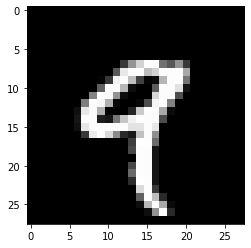

In [5]:
plt.imshow(trainset[4][0][0],cmap="gray")

In [6]:
#define whether to use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

C:\Users\Soundharya S\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

# Alex Network Structure

In [7]:
class AlexNet(nn.Module):
    def __init__(self,width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # 32*28*28
            nn.MaxPool2d(kernel_size=2, stride=2), # 32*14*14
            nn.ReLU(inplace=True),
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64*14*14
            nn.MaxPool2d(kernel_size=2, stride=2), # 64*7*7
            nn.ReLU(inplace=True),
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128*7*7
            )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # 256*7*7
            )
 
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # 256*7*7
            nn.MaxPool2d(kernel_size=3, stride=2), # 256*3*3
            nn.ReLU(inplace=True),
            )
        self.fc1 = nn.Linear(256*3*3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 256*3*3)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [8]:
# Hyper parameter settings
EPOCH = 5 # Number of times to traverse the data set
BATCH_SIZE = 64 # Batch size (batch_size)
LR = 0.01 # learning rate

In [9]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cpu()
        x = net(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total


In [10]:
net = AlexNet().to(device)

In [11]:
# Train and save model parameters
def train():
    # Define loss function loss function and optimization method (using SGD)
    # Cross entropy loss function, usually used formulti-classification problems
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)
    max_accuracy=0
    accuracies=[]
    for epoch in range(EPOCH):
                 # Data read
        for i, (images,labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
                         # Gradient clear
            optimizer.zero_grad()
 
            # forward + backward
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(criterion, testloader))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(criterion)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

Saving Best Model with Accuracy:  97.62999725341797
Epoch: 1 Accuracy : 97.62999725341797 %
Saving Best Model with Accuracy:  98.54000091552734
Epoch: 2 Accuracy : 98.54000091552734 %
Saving Best Model with Accuracy:  98.62999725341797
Epoch: 3 Accuracy : 98.62999725341797 %
Epoch: 4 Accuracy : 98.62000274658203 %
Saving Best Model with Accuracy:  98.93000030517578
Epoch: 5 Accuracy : 98.93000030517578 %


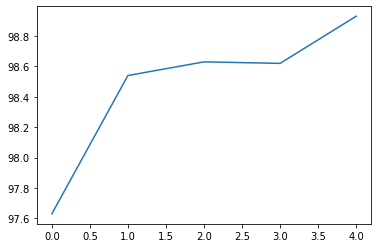

In [12]:
alexnet = train()

In [13]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cpu()
        x = net(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [15]:
y_pred, y_true = predict_dl(alexnet,testloader)

In [16]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,976,0,0,0,0,1,1,1,1,0
1,0,1130,0,4,0,0,0,1,0,0
2,1,2,1022,1,0,0,0,5,1,0
3,0,0,0,1010,0,0,0,0,0,0
4,0,1,3,0,967,0,0,3,1,7
5,1,0,0,12,0,877,0,0,1,1
6,2,4,0,2,3,9,935,0,3,0
7,0,1,7,0,0,0,0,1017,1,2
8,1,0,1,1,0,1,0,1,967,2
9,0,0,0,4,3,2,0,8,0,992


In [17]:
from io import BytesIO
import requests
from PIL import Image
import torch.nn.functional as F

# inference

In [18]:

def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = net(torch.unsqueeze(transform(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

In [19]:
path = "http://luisvalesilva.com/datasimple/images/digitre/b64_2_preprocessing_3.png"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

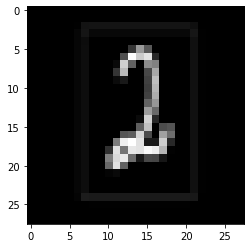

In [20]:
plt.imshow(x.squeeze(-1), cmap="gray")

# prediction

In [21]:

pred = inference(path, alexnet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 2, Prob: 98.30195307731628 %


In [22]:
pred

array([[7.1247356e-05, 3.5844184e-03, 9.8301953e-01, 9.0149660e-03,
        1.1138369e-03, 7.4300059e-04, 1.3122802e-04, 1.7770467e-03,
        5.0904328e-04, 3.5801237e-05]], dtype=float32)